In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from torch.nn import Sequential, Linear, ReLU, Conv2d, MaxPool2d, Flatten
from torch.utils.data import DataLoader
from tqdm import trange
import numpy as np
import matplotlib.pyplot as plt
import os
from skimage import io

from src.data.ucmerced_dataset import UcMercedDataset
from src.settings import DATA_DIRECTORY


In [3]:
dset = UcMercedDataset(DATA_DIRECTORY)

dataloader = DataLoader(dset, batch_size=50,
                        shuffle=True, num_workers=0)

In [4]:
import torch
from tqdm import tqdm, trange
from torch.nn import Sequential, Linear, ReLU, Conv2d, MaxPool2d, Flatten
model = Sequential(
    Conv2d(3, 32, (3, 3)),
    ReLU(),
    MaxPool2d(2, 2),
    Conv2d(32, 32, (3, 3)),
    ReLU(),
    MaxPool2d(2, 2),
    Conv2d(32, 64, (3, 3)),
    ReLU(),
    MaxPool2d(2, 2),
    Flatten(),
    Linear(57600, 100),
    ReLU(),
    Linear(100, 50)
)

model = model.cuda()
optim = torch.optim.Adam(model.parameters())
criterion = torch.nn.TripletMarginLoss()


t = trange(10)
for epoch in t:
    loss_sum = 0.0
    for i_batch, sample_batched in enumerate(dataloader):
        optim.zero_grad()
        anchors = sample_batched['a'].permute(0,3,1,2).float().cuda()
        positives = sample_batched['p'].permute(0,3,1,2).float().cuda()
        negatives = sample_batched['n'].permute(0,3,1,2).float().cuda()
        a = model(anchors)
        p = model(positives)
        n = model(negatives)
        loss = criterion(a, p, n)
        loss_sum += loss.item()
        loss.backward()
        optim.step()
        t.set_description(f"Batch: {i_batch}, loss: {loss.item()}")
        t.refresh()
    print(f"Epoch: {epoch}, Loss: {loss_sum / len(dataloader)}")

Batch: 41, loss: 0.2906559407711029: 100%|██████████| 10/10 [02:53<00:00, 17.38s/it]


Epoch: 0, Loss: 0.6264321576981318
Epoch: 1, Loss: 0.5338881037064961
Epoch: 2, Loss: 0.5135918862762905
Epoch: 3, Loss: 0.47721319113458904
Epoch: 4, Loss: 0.45236949409757343
Epoch: 5, Loss: 0.3768322819045612
Epoch: 6, Loss: 0.3614704293154535
Epoch: 7, Loss: 0.2800586142000698
Epoch: 8, Loss: 0.314730387713228
Epoch: 9, Loss: 0.29831838820661816


In [5]:
paths = []
embeddings = []
with torch.no_grad():
    for i_batch, sample_batched in enumerate(dataloader):
        anchors = sample_batched['a'].permute(0, 3, 1, 2).float().cuda()
        anchor_paths = sample_batched['path']
        paths.extend(anchor_paths)
        a = model(anchors).cpu()
        embeddings.append(a)

    embeddings = torch.cat(embeddings)

In [11]:
example = dset[0]
x, y, path = example['a'], example['a_y'], example['path']
x = torch.from_numpy(x)
x = torch.unsqueeze(x, 0)
x = x.permute(0, 3, 1, 2).float().cuda()
example_embedding = model(x).cpu()
distances = torch.cdist(example_embedding, embeddings)
sorting = torch.argsort(distances)
paths = np.array(paths)
sorting = sorting.squeeze().numpy()

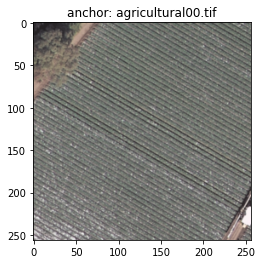

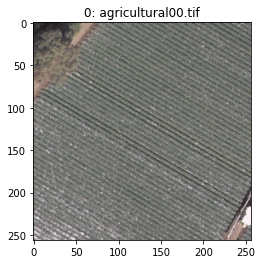

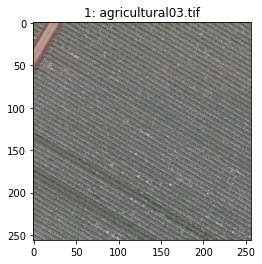

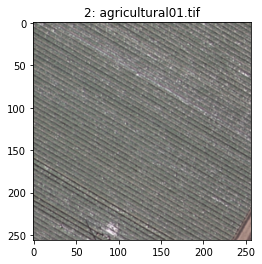

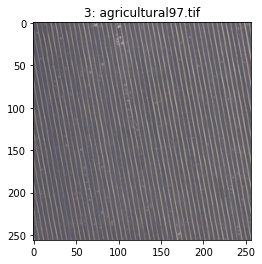

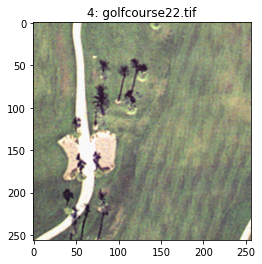

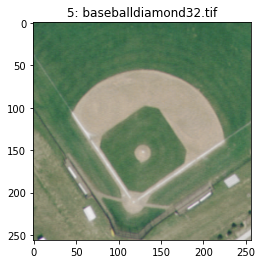

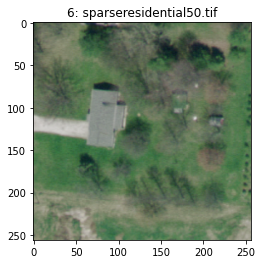

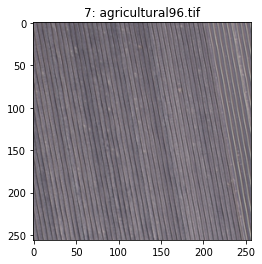

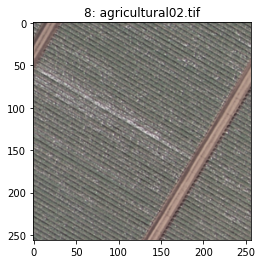

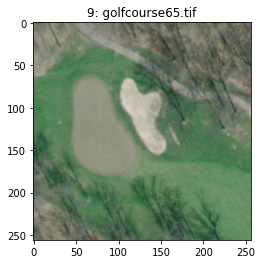

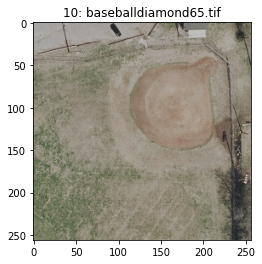

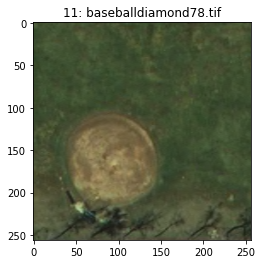

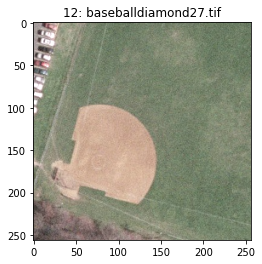

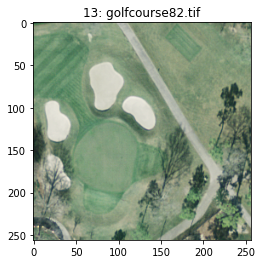

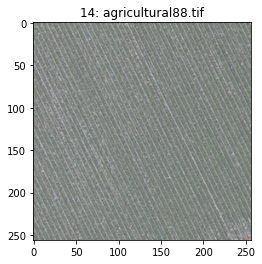

In [12]:
most_similar = paths[sorting]
ten_most_similar = most_similar[:15]
anchor_image = io.imread(path)
plt.tight_layout()
plt.title(f"anchor: {os.path.basename(path)}")
plt.imshow(anchor_image)
plt.show()
for i, p in enumerate(ten_most_similar):
    image = io.imread(p)
    plt.tight_layout()
    plt.title(f"{i}: {os.path.basename(p)}")
    plt.imshow(image)
    plt.show()